Se você é um iniciante, esses notebooks podem ajudar a ter um melhor entendimento do que será feito nesse notebook:

1. [Exploração de dados com Python][1] por **Pedro Marcelino** 

2. [Um estudo sobre Regressão aplicado ao conjunto de dados Ames][2] por **Julien Cohen-Solal**

3. [Modelos Lineares Regularizados][3] por **Alexandru Papiu**

4. [Script: XGBoost + Lasso][7] by **Human Analog**

A engenharia de features apresentadas neste notebook consistem em:

- **Preencher valores vazios**  por processamento dos dados

- **Transformar** variáveis numéricas que aparentam ser categóricas

- **Label Encoding** ou codificação de rótulos para algumas variáveis categóricas que podem conter alguma informação na ordem do seu conjunto.

- Transformação Box Cox ([**Box Cox Transformation**][4]) de recursos distorcidos (em vez de transformação de log)

- ** Obtendo variáveis dummy** para features categóricos. 

Então escolhemos muitos modelos básicos (a maioria dos modelos sklearn + API sklearn de DMLC [XGBoost] [5] e [LightGBM] [6] da Microsoft), utilizamos validação cruzada nos dados antes de empilhá-los / agrupá-los. A chave aqui é tornar os modelos (lineares) robustos para outliers. Isso melhorou o resultado tanto na LB quanto na validação cruzada.

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

### Importação das bibliotecas necessárias

In [4]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignorar warnings


from scipy import stats
from scipy.stats import norm, skew #para estatísticas


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #limitando floats para 3 decimais


from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8")) #checa os arquivos dentro do diretório

data_description.txt
sample_submission.csv
sample_submission.csv.gz
test.csv
test.csv.gz
train.csv
train.csv.gz



Os arquivos acima estão presentes dentro do diretório **input**

Agora vamos importar e colocar o conjunto de treino e teste no dataframe do pandas

In [10]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

mostra as primeiras 5 linhas do conjunto de treino

In [11]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


mostra as primeiras 5 linhas do conjunto de teste

In [12]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Agora vamos olhar a quantidade de observações e features temos em cada conjunto. Vamos também salvar a coluna **ID** do conjunto de treino e teste e depois removela do conjunto de dados, já que é um feature irrelevante para a atividade de predição

In [13]:
#checando o número de observações e features
print("O formado do dataframe de treino antes de remover a coluna id é : {} ".format(train.shape))
print("O formado do dataframe de teste antes de remover a coluna id é : {} ".format(test.shape))

#Salvando a culuna 'Id'
train_ID = train['Id']
test_ID = test['Id']

#Agora remova a coluna Id
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#checando mais uma vez o número de observações e features após a remoção da coluna 'Id'
print("O formado do dataframe de treino depois de remover a coluna id é : {} ".format(train.shape))
print("O formado do dataframe de teste depois de remover a coluna id é : {} ".format(test.shape))

O formado do dataframe de treino antes de remover a coluna id é : (1460, 81) 
O formado do dataframe de teste antes de remover a coluna id é : (1459, 80) 
O formado do dataframe de treino depois de remover a coluna id é : (1460, 80) 
O formado do dataframe de teste depois de remover a coluna id é : (1459, 79) 


# Processamento dos Dados

## Outliers

[A documentação][1] para os Dados de Habitação de Ames indica que existem outliers presentes nos dados de treino
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Vamos explorar esses outliers

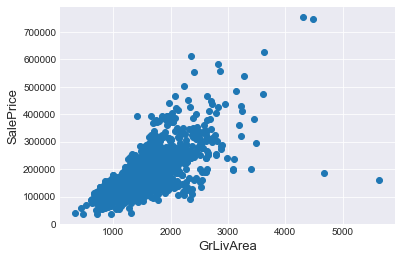

In [14]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Podemos ver na parte inferior direita dois com GrLivArea extremamente grandes que são de baixo preço. Esses valores são enormes oultliers.
Portanto, podemos excluí-los com segurança.

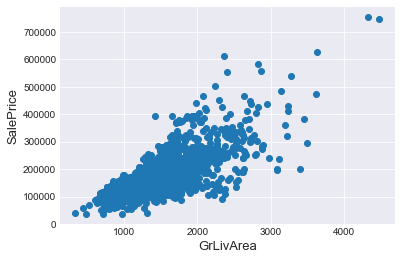

In [15]:
#Deletando outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Olhando o gráfico novamente
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Observação : 
Outliers removal is not always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

A remoção de outliers nem sempre é segura. Decidimos excluir estes dois como eles são muito grandes e muito ruins (áreas extremamente grandes para preços muito baixos).

Existem provavelmente outros valores discrepantes nos dados de treinamento. No entanto, removê-los pode afetar negativamente nossos modelos, se houer também outliers nos dados de teste. É por isso que, em vez de removê-los todos, só conseguiremos fazer alguns dos nossos modelos robustos neles.

## Variável alvo (Preço de venda das casas)

**SalePrice** é a variável que precisamos prever. Então, vamos fazer algumas análises sobre essa variável primeiro.


 mu = 180932.92 e sigma = 79467.79



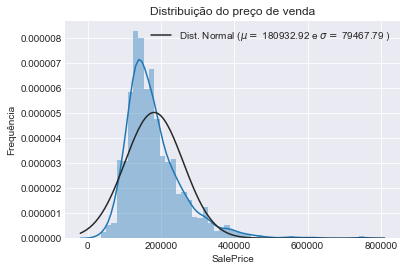

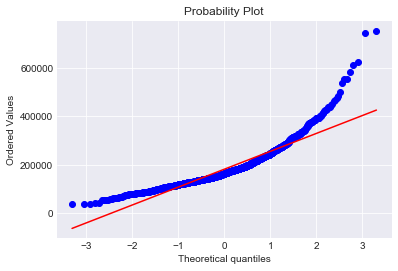

In [16]:
sns.distplot(train['SalePrice'] , fit=norm);

# Obtenha os parâmetros ajustados usados pela função
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} e sigma = {:.2f}\n'.format(mu, sigma))

#Agora plote a distribuição
plt.legend(['Dist. Normal ($\mu=$ {:.2f} e $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição do preço de venda')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

A variável de destino está à direita inclinada. Como os modelos (lineares) adoram dados normalmente distribuídos, precisamos transformar essa variável e torná-la mais normalmente distribuída.

 **Transformação log da variável alvo**


 mu = 12.02 e sigma = 0.40



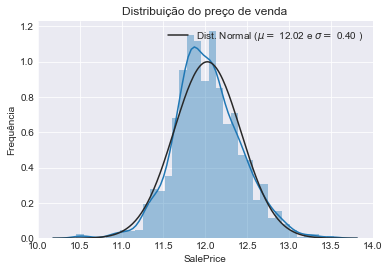

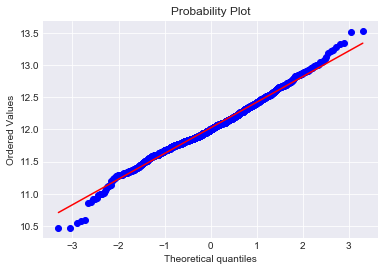

In [17]:
#Usamos a função numpy log1p que aplica log (1 + x) a todos os elementos da coluna
train["SalePrice"] = np.log1p(train["SalePrice"])

#Checa a nova distribuição
sns.distplot(train['SalePrice'] , fit=norm);

# Obtenha os parâmetros ajustados usados pela função
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} e sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Dist. Normal ($\mu=$ {:.2f} e $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição do preço de venda')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


A inclinação parece agora corrigida e os dados aparecem mais distribuída normalmente.

## Engenharia de features

Vamos primeiro concatenar o conjunto de treino e teste no mesmo dataframe

In [19]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("formato do dataframe com todos os dados é : {}".format(all_data.shape))

formato do dataframe com todos os dados é : (2917, 79)


### Valores vazios

In [20]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


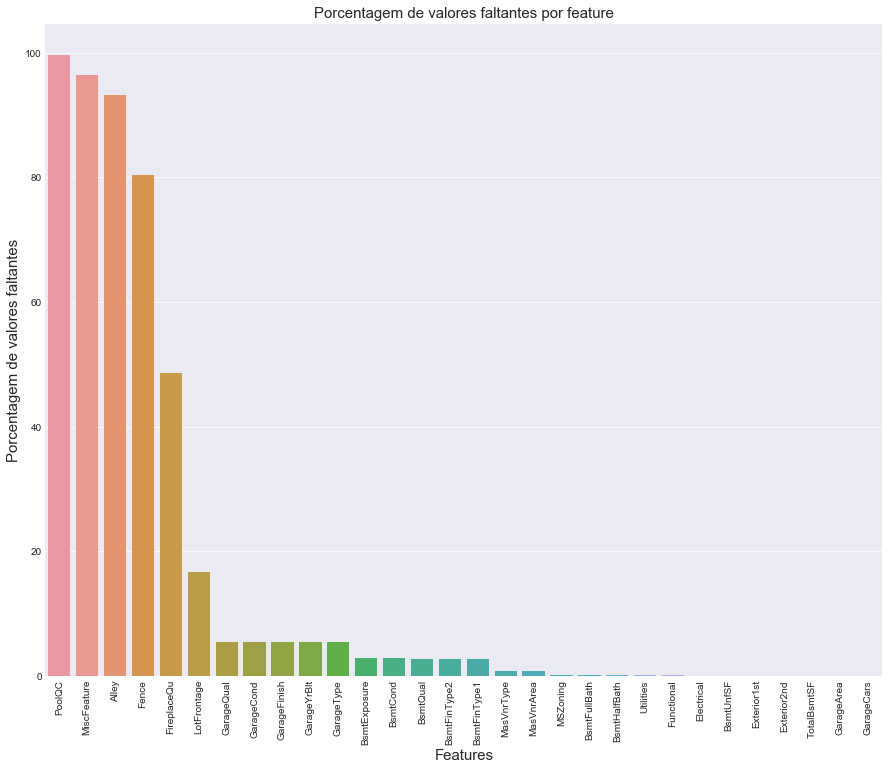

In [21]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Porcentagem de valores faltantes', fontsize=15)
plt.title('Porcentagem de valores faltantes por feature', fontsize=15)

**Correlação dos dados**


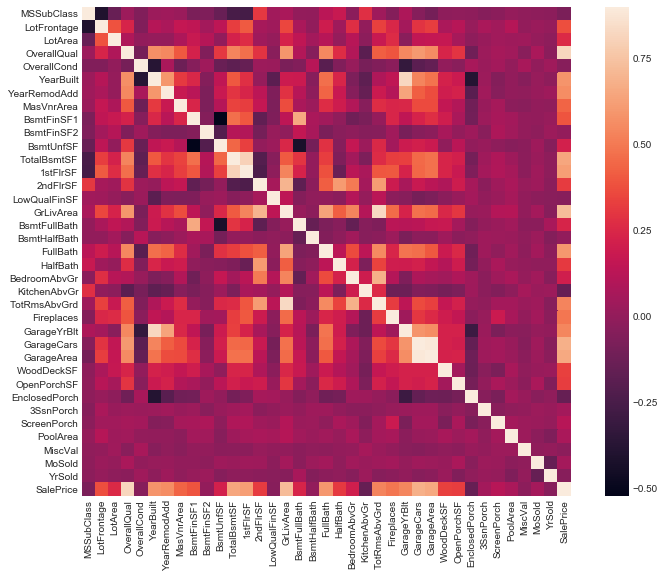

In [22]:
#Mapa de correlação para ver como os recursos estão correlacionados com o SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Preechendo valores vazios

Nós preenchemos os valores, procedendo sequencialmente por meio de recursos com valores ausentes

- **PoolQC** : a descrição dos dados diz que NA significa "Sem piscina". Isso faz sentido, dada a enorme proporção de falta de valor (+ 99%) e a maioria das casas não possuem piscina em geral.

In [23]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : descrição dos dados diz que NA significa "nenhum recurso variado"

In [24]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : descrição dos dados diz que NA significa "sem acesso ao beco"

In [25]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : descrição dos dados diz que NA significa "sem cerca"

In [26]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : descrição dos dados diz que NA significa "sem lareira"

In [27]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Como a área de cada rua conectada à propriedade da casa provavelmente tem uma área semelhante a outras casas em sua vizinhança, podemos **preencher os valores perdidos pela mediana LotFrontage do bairro**.

In [28]:
#Agrupe por bairro e preencha o valor em falta pela mediana LotFrontage de todo o bairro
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Trocando valores vazios por nenhum

In [29]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Substituindo dados vazios por 0 (já que não há garagem = sem carros em tal garagem).


In [30]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : valores vazios são provavelmente zero por não ter porão

In [31]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : Para todas essas características categóricas relacionadas ao porão, NaN significa que não há porão.

In [32]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA provavelmente significa que não há folheado de alvenaria para essas casas. Podemos preencher 0 para a área e None para o tipo.

In [33]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  RL' é de longe o valor mais comum. Assim, podemos preencher valores ausentes com 'RL'

In [34]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : Para este recurso categórico, todos os registros são "AllPub", com exceção de um "NoSeWa" e 2 NA. Como a casa com 'NoSewa' está no conjunto de treinamento, **esse feature não ajudará na modelagem preditiva**. Podemos, então, removê-lo com segurança.


In [35]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : descrição dos dados diz NA significa típico

In [36]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : Tem um valor de NA. Como esse recurso tem principalmente 'SBrkr', podemos definir isso para o valor ausente.


In [37]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Apenas um valor de NA, e igual a Electrical, definimos 'TA' (que é o mais frequente) para o valor faltante no KitchenQual.

In [38]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Novamente ambos os Exterior 1 e 2 têm apenas um valor em falta. Vamos apenas substituir na string mais comum

In [39]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Preencha novamente com mais frequente que é "WD"

In [40]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : NA provavelmente significa que não há classe de construção. Podemos substituir valores ausentes por Nenhum


In [41]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Existe algum valor vazio? 

In [42]:
#Verificando os valores ausentes restantes, se houver
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


Não tem nada faltando

### Mais Engenharia de features

**Transformando algumas variáveis numéricas que são realmente categóricas**

In [43]:
#MSSubClass = A classe de construção
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Mudando OverallCond em uma variável categórica
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Ano e mes que foi vendida são transformadas em variáveis categóricas.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)



**Label Encoding algumas variáveis categóricas que podem conter informações na ordem do seu conjunto** 

In [45]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# processando colunas, aplica o LabelEncoder para atributos categóricos
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# formato        
print('Formato all_data: {}'.format(all_data.shape))

Formato all_data: (2917, 78)


**Adicionando um importante feature**

Como as características relacionadas à área são muito importantes para determinar os preços das casas, adicionamos mais uma característica que é a área total das áreas de subsolo, primeiro e segundo andar de cada casa.

In [46]:
# adicionando o total square footage (total da area da casa)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Features distorcidos**

In [47]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# checando a inclinação de todos os feature numericos
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


**Transformação Box Cox de features (altamente) distorcidos**

Usamos a função scipy boxcox1p que calcula a transformação Box-Cox de ** \\ (1 + x \\) **.

Observe que a configuração \\(\lambda = 0 \\) é equivalente a log1p usado acima para a variável de destino.

Veja [essa página][1] para mais detalhes sobre Transformação Box Cox, bem como [a página do scipy sobre a função][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [48]:
skewness = skewness[abs(skewness) > 0.75]
print("Existem {} features numéricos distorcidas para a transformação Box Cox".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

Existem 59 features numéricos distorcidas para a transformação Box Cox


**Obtendo as variáveis dummy para os features categóricos**

In [49]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


Obtendo os novos conjuntos de treino e teste.

In [50]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelando

**Importando as bibliotecas**

In [55]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

**Definindo uma estratégia de validação cruzada**

Nós usamos a função **cross_val_score** do Sklearn. No entanto, esta função não tem um atributo shuffle, nós adicionamos então uma linha de código, a fim de embaralhar o dataset antes da validação cruzada.

In [56]:
#Função de validação
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Modelos bases

-  **LASSO  Regression**  : 

Este modelo pode ser muito sensível a outliers. Então, precisamos torná-lo mais robusto para eles. Para isso, usamos o método **Robustscaler()** do sklearn no pipeline.

In [57]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

Novament, o tornamos robusto para outliers

In [58]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [59]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

Com perda de **huber** que o torna robusto para outliers
    

In [60]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [61]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- **LightGBM** :

In [62]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Pontuação dos modelos bases

Vamos ver como esses modelos base executam os dados avaliando o erro rmsle de validação cruzada

In [64]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [65]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [66]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [67]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [68]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1161 (0.0079)



In [69]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1162 (0.0071)



## Modelos de empilhamento

### Abordagem de empilhamento mais simples : Usando a média dos modelos bases

Começamos com essa abordagem simples de calcular os modelos bases. Nós construímos uma nova **classe** para estender o scikit-learn com nosso modelo e também para encapsulamento médio e reutilização de código ([herança] [1])
[1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Classe que usa a média dos modelos bases**

In [70]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # nós definimos clones dos modelos originais para ajustar os dados 
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Agora fazemos as previsões para modelos clonados e calculamos a média deles
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Pontuação da média dos modelos bases**

Nós apenas medimos quatro modelos aqui **ENet, GBoost, KRR e lasso**. Claro que poderíamos facilmente adicionar mais modelos na mistura.

In [71]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0075)



Uau ! Parece que até mesmo a abordagem de empilhamento mais simples realmente melhora a pontuação. Isso nos encoraja a ir mais longe e explorar uma abordagem de empilhamento menos simples.

### Empilhamento menos simples: Adicionando um Meta-modelo

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.

Nesta abordagem, adicionamos um meta-modelo em modelos de base média e usamos as previsões desses modelos básicos para treinar nosso meta-modelo.

O procedimento, para a parte de treinamento, pode ser descrito da seguinte forma:


1. Divida o conjunto de treinamento em dois conjuntos disjuntos (aqui **treino** e. **espera**)

2. Treine vários modelos básicos na primeira parte (**treino**)

3. Teste esses modelos básicos na segunda parte (**espera**)

4. Use as previsões de 3) (chamadas predições fora de dobra) como entradas, e as respostas corretas (variável-alvo) como saídas para treinar um aprendiz de nível mais alto chamado **meta-modelo**.

Os três primeiros passos são feitos iterativamente. Se tomarmos por exemplo um empilhamento de 5 vezes, primeiro dividimos os dados de treinamento em 5 dobras. Então faremos 5 iterações. Em cada iteração, treinamos cada modelo base em 4 dobras e prevemos a dobra restante (dobra de espera).

Assim, teremos a certeza, após 5 iterações, de que os dados inteiros são usados para obter previsões fora de dobra que usaremos como novo feature para treinar nosso meta-modelo na etapa 4.

Para a parte de previsão, calculamos a média das previsões de todos os modelos de base nos dados de teste e as usamos como **meta-features** nas quais a previsão final é feita com o meta-modelo.


![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Imagem extraída de [Faron](https://www.kaggle.com/getting-started/18153#post103381))

**Classe de Empilhamento de modelos base em média**

In [73]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # Voltamos a encaixar os dados em clones dos modelos originais
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Treinando modelos base clonados e criar previsões fora do prazo
        # que são necessários para treinar o metamodelo clonado
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Agora treine o meta-modelo clonado usando as previsões fora do ciclo como novo feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Faça as previsões de todos os modelos básicos nos dados de teste e use as previsões médias como
    #meta-características para a previsão final que é feita pelo meta-modelo 
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Pontuação do modelo de empilhamento em média**

Para tornar as duas abordagens comparáveis (usando o mesmo número de modelos), nós apenas classificamos **Enet KRR e Gboost**, então adicionamos **lasso como meta-modelo**.

In [74]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0074)


Conseguimos um resultado ainda melhor

## Juntando StackedRegressor, XGBoost e LightGBM

Adicionamos **XGBoost e LightGBM** ao StackedRegressor definido anteriormente.

Primeiro definimos uma função de avaliação rmsle

In [75]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

**StackedRegressor:**

In [76]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07815719379165137


**XGBoost:**

In [77]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0785165142425036


**LightGBM:**

In [78]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07307464036005418


In [79]:
'''RMSE em todos os dados do treino ao calcular a média'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07541098364121598


**Ensemble prediction:**

In [80]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [81]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)